# demo.ipynb — Load Model and Predict from Webcam (Colab)
This notebook mounts Google Drive, loads the saved MNIST CNN model, captures images from webcam in Colab, preprocesses them, and predicts the digit.


In [102]:

# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
MODEL_DIR = '/content/drive/MyDrive/mnist_digit_cnn'
print('Model dir:', MODEL_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model dir: /content/drive/MyDrive/mnist_digit_cnn


In [103]:

# 2) Imports and model loading
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os, json, io, base64
from PIL import Image
from google.colab import output

model_path = os.path.join(MODEL_DIR, 'mnist_cnn.h5')
assert os.path.exists(model_path), f'Model not found at {model_path}. Run digit.ipynb first.'
model = keras.models.load_model(model_path)
with open(os.path.join(MODEL_DIR, 'label_map.json'), 'r') as f:
    label_map = json.load(f)
print('Model and label map loaded.')


Model and label map loaded.


In [104]:
# 3) Utility: Webcam capture in Colab via JavaScript

from google.colab import output
import io, base64
from PIL import Image

def take_photo(quality=0.95):
    js = '''
    async function takePhoto(quality) {
      const wrapper = document.createElement('div');
      wrapper.style.display = 'inline-block';
      wrapper.style.padding = '8px';
      wrapper.style.border = '1px solid #ccc';
      wrapper.style.borderRadius = '12px';
      wrapper.style.margin = '6px 0';
      wrapper.style.background = '#fafafa';
      wrapper.style.fontFamily = 'system-ui, -apple-system, Segoe UI, Roboto, sans-serif';

      const title = document.createElement('div');
      title.textContent = 'Live preview — click Capture when ready';
      title.style.marginBottom = '6px';
      wrapper.appendChild(title);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.style.maxWidth = '480px';
      video.style.borderRadius = '8px';
      video.style.boxShadow = '0 0 8px rgba(0,0,0,0.15)';
      wrapper.appendChild(video);

      const controls = document.createElement('div');
      controls.style.marginTop = '6px';

      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      capture.style.fontSize = '16px';
      capture.style.padding = '8px 14px';
      capture.style.borderRadius = '8px';
      capture.style.cursor = 'pointer';
      capture.style.border = '1px solid #222';

      const cancel = document.createElement('button');
      cancel.textContent = '✖ Cancel';
      cancel.style.marginLeft = '8px';
      cancel.style.padding = '8px 14px';
      cancel.style.borderRadius = '8px';
      cancel.style.cursor = 'pointer';
      cancel.style.border = '1px solid #666';

      controls.appendChild(capture);
      controls.appendChild(cancel);
      wrapper.appendChild(controls);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(wrapper);
      video.srcObject = stream;
      await new Promise((resolve) => { video.onloadedmetadata = resolve; });
      video.play();

      // Wait for the user's choice
      const choice = await new Promise((resolve) => {
        capture.onclick = () => resolve('capture');
        cancel.onclick = () => resolve('cancel');
      });

      let dataURL = null;
      if (choice === 'capture') {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        dataURL = canvas.toDataURL('image/jpeg', quality);
      }

      // Cleanup
      stream.getTracks().forEach(t => t.stop());
      wrapper.remove();
      return dataURL;
    }
    takePhoto(%f);
    ''' % quality

    data = output.eval_js(js)
    if not data:
        raise RuntimeError('Capture cancelled.')
    binary = base64.b64decode(data.split(',')[1])
    return Image.open(io.BytesIO(binary))


In [105]:

# 4) Preprocess captured image for MNIST (28x28, white digit on black bg)
def preprocess_for_mnist(img_pil, debug=False):
    # Convert to OpenCV BGR
    img = np.array(img_pil.convert('RGB'))[:, :, ::-1].copy()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur & threshold to isolate dark digit on white paper
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Otsu threshold (invert so digit becomes white on black)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours and choose the largest area blob
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise RuntimeError('No contours found. Try moving closer or using darker marker.')
    c = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    digit_roi = th[y:y+h, x:x+w]

    # Pad to square
    size = max(w, h)
    square = np.zeros((size, size), dtype=np.uint8)
    # center the crop
    x_off = (size - w) // 2
    y_off = (size - h) // 2
    square[y_off:y_off+h, x_off:x_off+w] = digit_roi

    # Resize to 28x28
    resized = cv2.resize(square, (28,28), interpolation=cv2.INTER_AREA)

    # Normalize to [0,1] and add channel + batch dims
    tensor = resized.astype('float32') / 255.0
    tensor = np.expand_dims(tensor, axis=-1)   # (28,28,1)
    tensor = np.expand_dims(tensor, axis=0)    # (1,28,28,1)

    if debug:
        from google.colab.patches import cv2_imshow
        print('Grayscale -> Thresholded (inverted) -> ROI -> 28x28')
        cv2_imshow(gray)
        cv2_imshow(th)
        cv2_imshow(digit_roi)
        cv2_imshow(resized)

    return tensor, resized


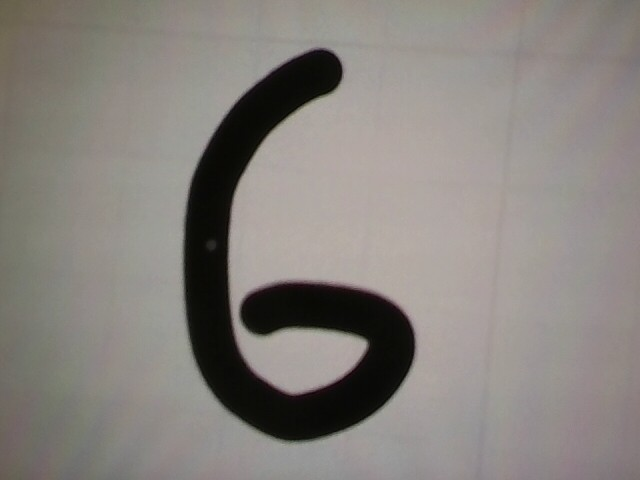

Grayscale -> Thresholded (inverted) -> ROI -> 28x28


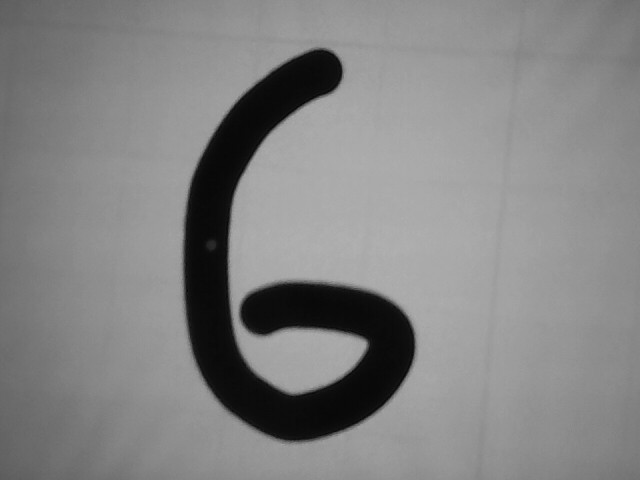

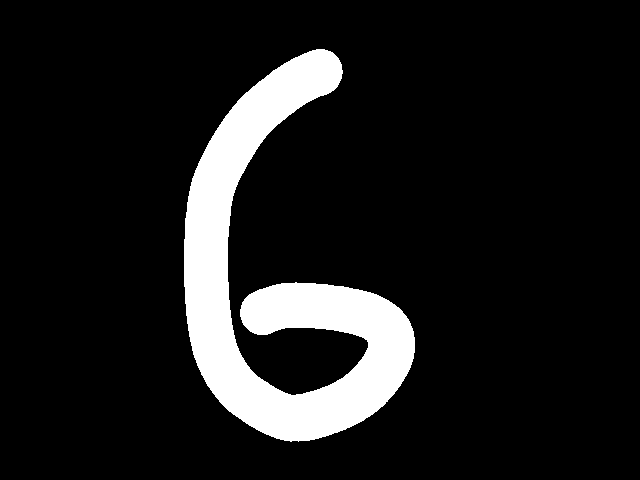

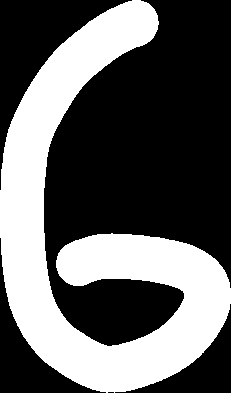

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted: 6 ("6") with confidence 0.9856


In [106]:

# 5) Capture, preprocess, and predict
try:
    img = take_photo(quality=0.9)
    display(img)
    x, vis = preprocess_for_mnist(img, debug=True)
    preds = model.predict(x)
    prob = float(np.max(preds))
    cls = int(np.argmax(preds))
    print(f'Predicted: {cls} ("{label_map[str(cls)]}") with confidence {prob:.4f}')
except Exception as e:
    print('Error:', e)
    print('Tips: Ensure good lighting, large dark digit on white paper, and hold steady close to the camera.')
